# 10_ImageAlignement_Testing
### B3 Statistik am Baum ohne Boden und bereinigt (Partikel im Raum)
In diesem Jupyter Notebook werden Statistiken aus Daten Confidence-Werten der Punktwolken verschiedener ImageAlignement-Methoden generiert.

Die Daten basieren auf Bildern der DJI Mini 3 Pro 26.03.2025.
In diesem Jupyter Notebook werden Statistiken aus Daten Confidence-Werten der Punktwolken verschiedener ImageAlignement-Methoden generiert.

Die Daten basieren auf Bildern der DJI Mini 3 Pro 26.03.2025.

### Import der Libraries

In [1]:
import pandas as pd
import glob
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import laspy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
import traceback

### Definition der Grundlagedaten und Anzeige Maximaler Confidence Wert sowie Anzahl Punkte pro Punktwolke

In [2]:
# PointCloud-Verzeichnis 
pc_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree_cleaned"
print("Daten in PointCloud-Verzeichnis:", os.listdir(pc_dir))

# Überprüfen, ob das Verzeichnis existiert
if not os.path.exists(pc_dir):
    raise FileNotFoundError(f"Verzeichnis nicht gefunden: {pc_dir}")

# Liste aller LAS-Dateien im Ordner
las_files = [f for f in os.listdir(pc_dir) if f.lower().endswith(".las")]

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(pc_dir, "*.las")))
if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {pc_dir}")

# Funktion zum Extrahieren der Confidence-Werte
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Confidence-Werte aller Dateien sammeln
confidence_data = {}
min_vals, max_vals = [], []

for file in las_files:
    try:
        conf = get_confidence_values(file)
        confidence_data[file] = conf
        min_vals.append(np.min(conf))
        max_vals.append(np.max(conf))
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Gemeinsamer Wertebereich für alle Histogramme
max_conf = max(max_vals)

print(f"Maximaler Confidence-Wert aller Punktwolken: {max_conf}")

# Für jede Datei wird die Anzahl der Punkte ermittelt und ausgegeben.
for filename in las_files:
    file_path = os.path.join(pc_dir, filename)
    las = laspy.read(file_path)
    # Anzahl der Punkte (als Länge des Arrays der Punktdaten)
    num_points = len(las.points)
    print(f"{filename}: {num_points} Punkte")


Daten in PointCloud-Verzeichnis: ['01_Generic_Preselection_source_guided_matching_NO_tree_manually-cleaned.las', '02_Generic_Preselection_estimated_guided_matching_NO_tree_manually-cleaned.las', '03_Generic_Preselection_source_guided_matching_YES_tree_manually-cleaned.las', '04_Generic_Preselection_estimated_guided_matching_YES_tree_manually-cleaned.las']
Maximaler Confidence-Wert aller Punktwolken: 70.0
D:\BTh11_Asuwertung_PC\fhnw_code\BTh11_Trieblaengenwachstum\10_ImageAlignement_Testing\100_BaseData\PointCloud\pc_tree_cleaned\01_Generic_Preselection_source_guided_matching_NO_tree_manually-cleaned.las: 45244280 Punkte
D:\BTh11_Asuwertung_PC\fhnw_code\BTh11_Trieblaengenwachstum\10_ImageAlignement_Testing\100_BaseData\PointCloud\pc_tree_cleaned\02_Generic_Preselection_estimated_guided_matching_NO_tree_manually-cleaned.las: 45745553 Punkte
D:\BTh11_Asuwertung_PC\fhnw_code\BTh11_Trieblaengenwachstum\10_ImageAlignement_Testing\100_BaseData\PointCloud\pc_tree_cleaned\03_Generic_Preselectio

## 2. Analyse Punktwolken (clipped) 
Die Punkwolken werden aufgrund der Attribute analysiert, um eine Erkenntnis aus den verschiedenen Aufnahmedaten zu erhalten.

### 2.1 Histogramm der Confidence-Werte der Punktwolken in Kategorien [Dezimalskala]
In dieser Visualisierung werden alle Punkte der Punktwolken in Bezug auf das Attribut "confidence" in Kategorien eingeteilt. Pro Kategorie werden die normierten Anteile oder die Anzahl Punkte pro ImageAlignement-Methode dargestellt.

Kategorien:
 - Einzelwerte: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
 - 5-Punkte-Intervall: 11-15, 16-20
 - 10-Punkte-Intervall: 21-30, 31-40, 41-50, 51-60, 61-70

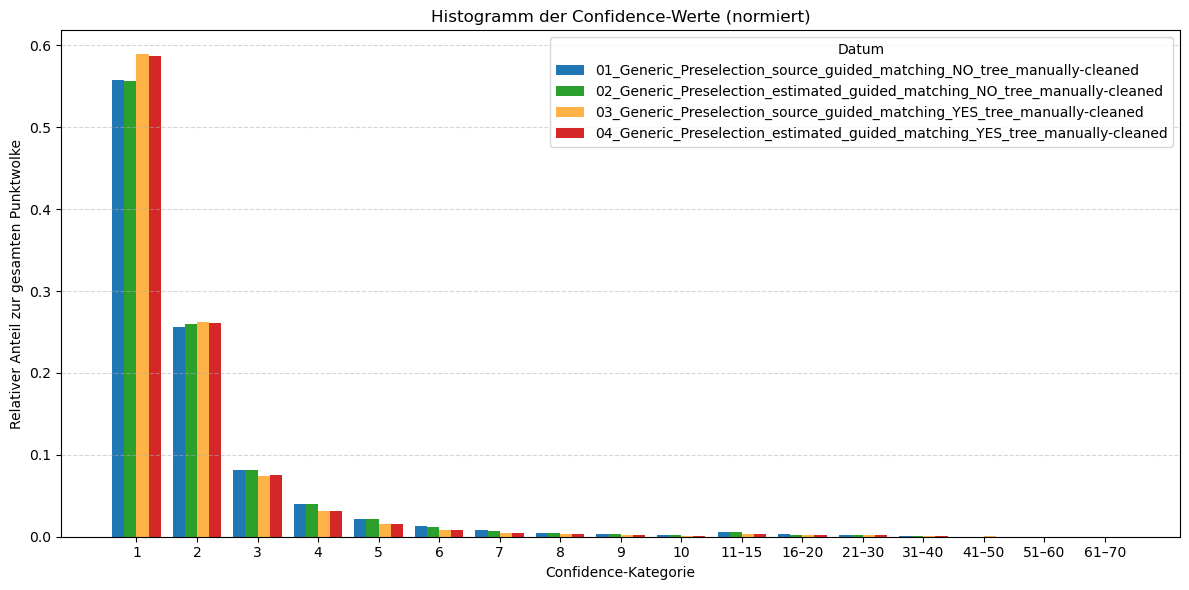

In [3]:
#============================================ Histogramm-Confidence-Werte - NORMIERT / DEZIMALSKALA ============================================

import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree_cleaned"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))

if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Bins nach benutzerdefinierten Bereichen
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 21, 31, 41, 51, 61, 71]
bin_labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
              "11–15", "16–20", "21–30", "31–40", "41–50", "51–60", "61–70"]


# Funktion zur Berechnung des normalisierten Histogramms der Confidence-Werte
def compute_confidence_histogram(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    confidence = las['confidence']
    counts, _ = np.histogram(confidence, bins=bins)
    total = np.sum(counts)
    norm_counts = counts / total if total > 0 else np.zeros_like(counts)
    return norm_counts

# Farbpalette (z. B. aus Tableau / Plotly / ColorBrewer etc.)
colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]

# Histogramme berechnen und speichern
hist_data = []
labels = []

for idx, file in enumerate(las_files):
    try:
        hist = compute_confidence_histogram(file)
        hist_data.append(hist)
        # Optional: Nur das Datum aus dem Dateinamen extrahieren
        basename = os.path.basename(file)
        label = os.path.splitext(basename)[0]  # z.B. "20250224"
        labels.append(label)
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file}: {e}")

# Plot vorbereiten
x = np.arange(len(bin_labels))  # Positionen der Kategorien
width = 0.8 / len(hist_data)  # Balkenbreite dynamisch anpassen

fig, ax = plt.subplots(figsize=(12, 6))

# Für jede Datei Balken zeichnen
for i, (hist, label) in enumerate(zip(hist_data, labels)):
    offset = (i - len(hist_data)/2) * width + width/2
    ax.bar(x + offset, hist, width=width, label=label, color=colors[i % len(colors)])

# Achsen & Layout
ax.set_xticks(x)
ax.set_xticklabels(bin_labels)
ax.set_xlabel("Confidence-Kategorie")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke")
ax.set_title("Histogramm der Confidence-Werte (normiert)")
ax.legend(title="Datum")
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()



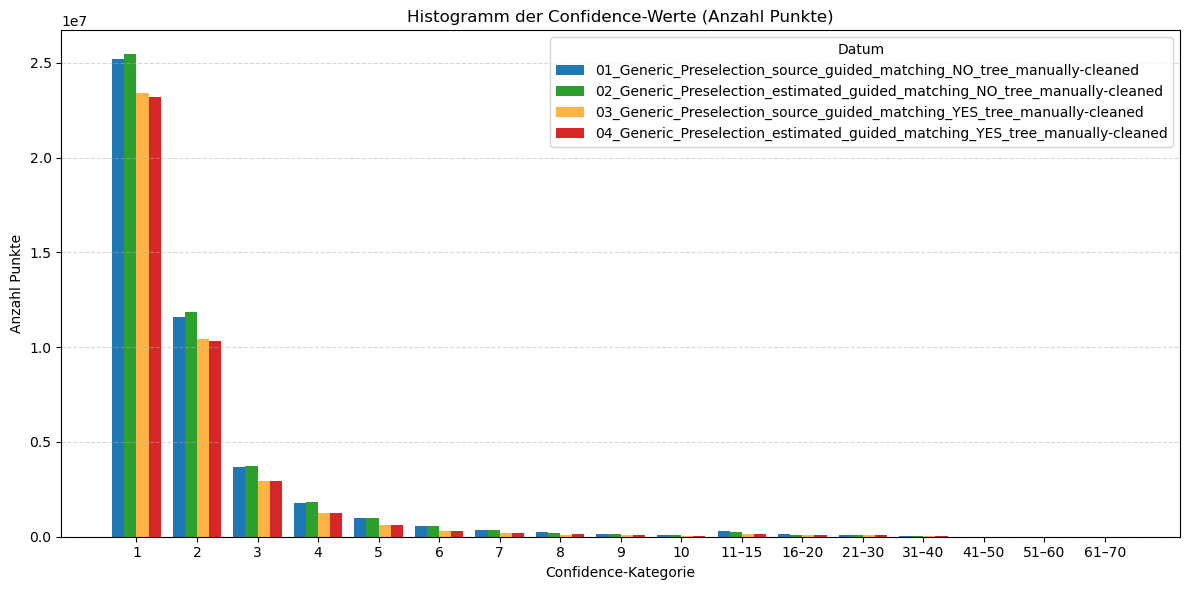

In [4]:
#============================================ Histogramm-Confidence-Werte - ANZAHL PUNKTE / DEZIMALSKALA ============================================

import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree_cleaned"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))

if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Bins nach benutzerdefinierten Bereichen
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 21, 31, 41, 51, 61, 71]
bin_labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
              "11–15", "16–20", "21–30", "31–40", "41–50", "51–60", "61–70"]


# Funktion zur Berechnung des normalisierten Histogramms der Confidence-Werte
def compute_confidence_histogram(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    confidence = las['confidence']
    counts, _ = np.histogram(confidence, bins=bins)
    return counts

# Farbpalette (z. B. aus Tableau / Plotly / ColorBrewer etc.)
colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]

# Histogramme berechnen und speichern
hist_data = []
labels = []

for idx, file in enumerate(las_files):
    try:
        hist = compute_confidence_histogram(file)
        hist_data.append(hist)
        # Optional: Nur das Datum aus dem Dateinamen extrahieren
        basename = os.path.basename(file)
        label = os.path.splitext(basename)[0]  # z.B. "20250224"
        labels.append(label)
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file}: {e}")

# Plot vorbereiten
x = np.arange(len(bin_labels))  # Positionen der Kategorien
width = 0.8 / len(hist_data)  # Balkenbreite dynamisch anpassen

fig, ax = plt.subplots(figsize=(12, 6))

# Für jede Datei Balken zeichnen
for i, (hist, label) in enumerate(zip(hist_data, labels)):
    offset = (i - len(hist_data)/2) * width + width/2
    ax.bar(x + offset, hist, width=width, label=label, color=colors[i % len(colors)])

# Achsen & Layout
ax.set_xticks(x)
ax.set_xticklabels(bin_labels)
ax.set_xlabel("Confidence-Kategorie")
ax.set_ylabel("Anzahl Punkte")
ax.set_title("Histogramm der Confidence-Werte (Anzahl Punkte)")
ax.legend(title="Datum")
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()



### 2.2 Histogramm der Confidence-Werte der Punktwolken in Kategorien [Dezimalskala]
In dieser Visualisierung werden alle Punkte der Punktwolken in Bezug auf das Attribut "confidence" in Kategorien eingeteilt. Pro Kategorie werden die normierten Anteile oder die Anzahl Punkte pro ImageAlignement-Methode dargestellt.

Kategorien:
 - Einzelwerte: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
 - 5-Punkte-Intervall: 11-15, 16-20
 - 10-Punkte-Intervall: 21-30, 31-40, 41-50, 51-60, 61-70

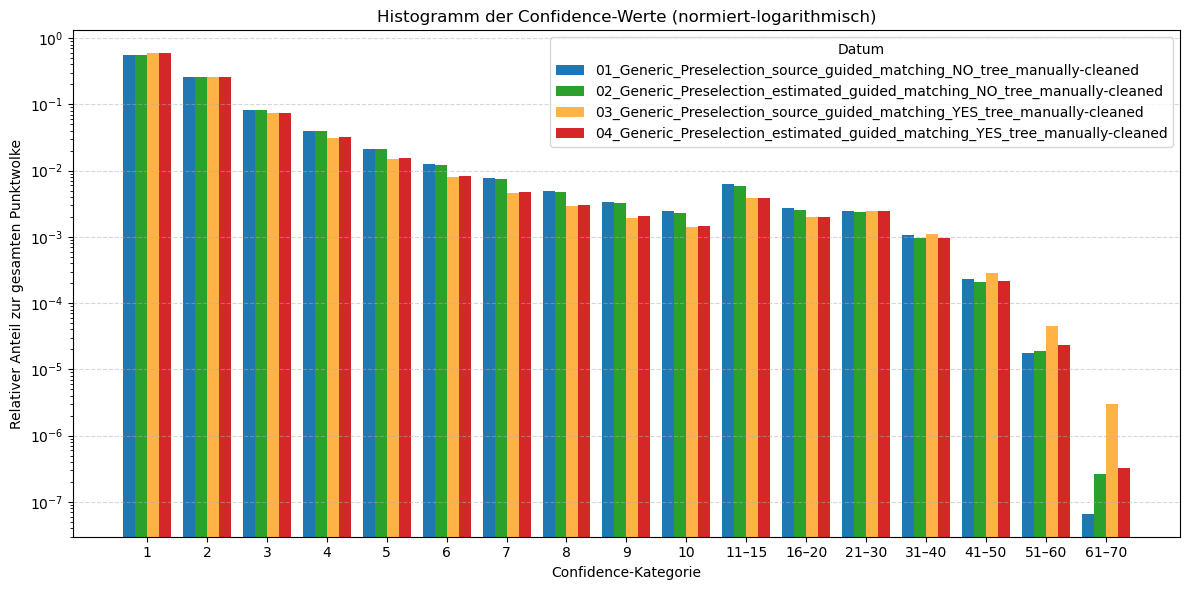

In [5]:
#============================================ Histogramm-Confidence-Werte - NORMIERT / LOGARITHMISCH ============================================

import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree_cleaned"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))

if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Bins nach benutzerdefinierten Bereichen
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 21, 31, 41, 51, 61, 71]
bin_labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
              "11–15", "16–20", "21–30", "31–40", "41–50", "51–60", "61–70"]


# Funktion zur Berechnung des normalisierten Histogramms der Confidence-Werte
def compute_confidence_histogram(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    confidence = las['confidence']
    counts, _ = np.histogram(confidence, bins=bins)
    total = np.sum(counts)
    norm_counts = counts / total if total > 0 else np.zeros_like(counts)
    return norm_counts

# Farbpalette (z. B. aus Tableau / Plotly / ColorBrewer etc.)
colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]

# Histogramme berechnen und speichern
hist_data = []
labels = []

for idx, file in enumerate(las_files):
    try:
        hist = compute_confidence_histogram(file)
        hist_data.append(hist)
        # Optional: Nur das Datum aus dem Dateinamen extrahieren
        basename = os.path.basename(file)
        label = os.path.splitext(basename)[0]  # z.B. "20250224"
        labels.append(label)
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file}: {e}")

# Plot vorbereiten
x = np.arange(len(bin_labels))  # Positionen der Kategorien
width = 0.8 / len(hist_data)  # Balkenbreite dynamisch anpassen

fig, ax = plt.subplots(figsize=(12, 6))

# Für jede Datei Balken zeichnen
for i, (hist, label) in enumerate(zip(hist_data, labels)):
    offset = (i - len(hist_data)/2) * width + width/2
    ax.bar(x + offset, hist, width=width, label=label, color=colors[i % len(colors)])

# Achsen & Layout
ax.set_xticks(x)
ax.set_xticklabels(bin_labels)
ax.set_xlabel("Confidence-Kategorie")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke")
ax.set_title("Histogramm der Confidence-Werte (normiert-logarithmisch)")
ax.set_yscale("log")
ax.legend(title="Datum")
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

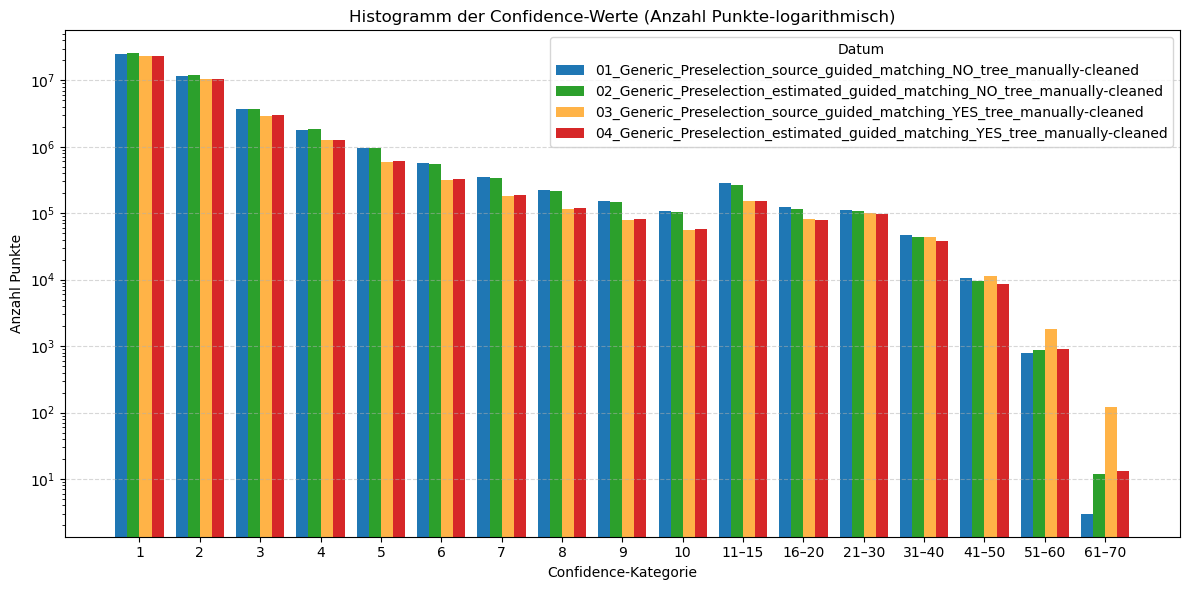

In [6]:
#============================================ Histogramm-Confidence-Werte - ANZAHL PUNKTE / LOGARITHMISCH ============================================

import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree_cleaned"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))

if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Bins nach benutzerdefinierten Bereichen
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 21, 31, 41, 51, 61, 71]
bin_labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
              "11–15", "16–20", "21–30", "31–40", "41–50", "51–60", "61–70"]


# Funktion zur Berechnung des normalisierten Histogramms der Confidence-Werte
def compute_confidence_histogram(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    confidence = las['confidence']
    counts, _ = np.histogram(confidence, bins=bins)
    return counts

# Farbpalette (z. B. aus Tableau / Plotly / ColorBrewer etc.)
colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]

# Histogramme berechnen und speichern
hist_data = []
labels = []

for idx, file in enumerate(las_files):
    try:
        hist = compute_confidence_histogram(file)
        hist_data.append(hist)
        # Optional: Nur das Datum aus dem Dateinamen extrahieren
        basename = os.path.basename(file)
        label = os.path.splitext(basename)[0]  # z.B. "20250224"
        labels.append(label)
    except Exception as e:
        print(f"Fehler beim Verarbeiten von {file}: {e}")

# Plot vorbereiten
x = np.arange(len(bin_labels))  # Positionen der Kategorien
width = 0.8 / len(hist_data)  # Balkenbreite dynamisch anpassen

fig, ax = plt.subplots(figsize=(12, 6))

# Für jede Datei Balken zeichnen
for i, (hist, label) in enumerate(zip(hist_data, labels)):
    offset = (i - len(hist_data)/2) * width + width/2
    ax.bar(x + offset, hist, width=width, label=label, color=colors[i % len(colors)])

# Achsen & Layout
ax.set_xticks(x)
ax.set_xticklabels(bin_labels)
ax.set_xlabel("Confidence-Kategorie")
ax.set_ylabel("Anzahl Punkte")
ax.set_title("Histogramm der Confidence-Werte (Anzahl Punkte-logarithmisch)")
ax.set_yscale("log")
ax.legend(title="Datum")
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()



### 2.3 Histogramm der Confidence-Werte der Punktwolken (kontinuierlich) [Dezimalskala]
In dieser Visualisierung werden alle Punkte der Punktwolken in Bezug auf das Attribut "confidence" kontinuierlich (pro Wert eine Kategorie) eingeteilt. Pro Kategorie werden die normierten Anteile oder die Anzahl Punkte pro ImageAlignement-Methode dargestellt.


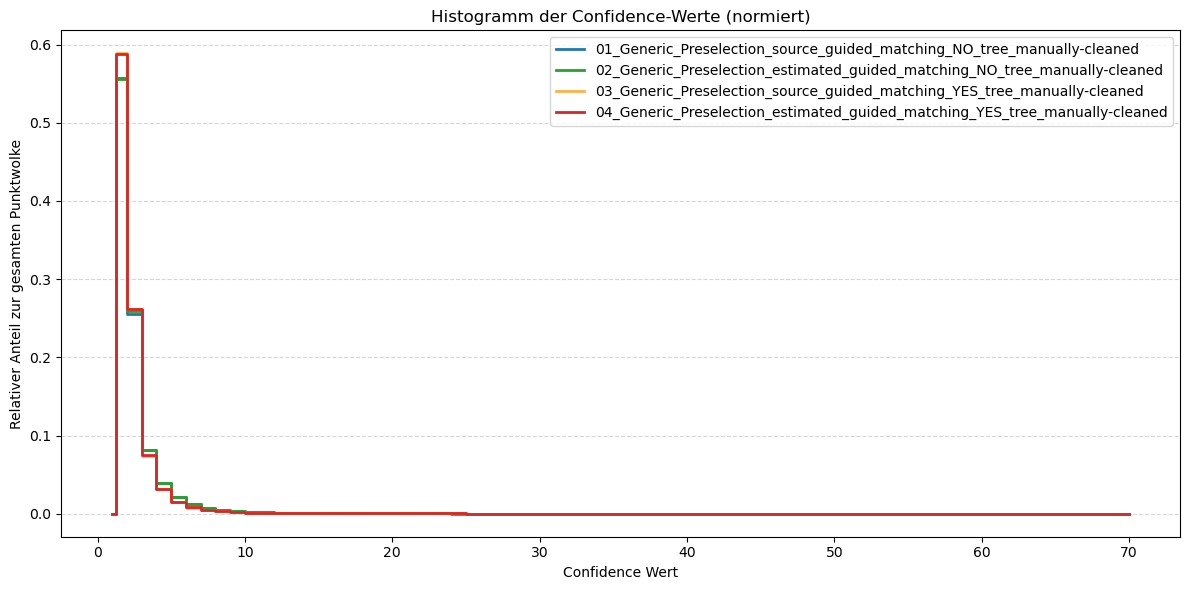

In [7]:
#============================================ Histogramm-Confidence-Werte - NORMIERT / DEZIMALSKALA ============================================

import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree_cleaned"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))
if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Funktion, um Confidence-Werte zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Daten vorbereiten
confidence_data = {}
min_vals = []
max_vals = []

for file in las_files:
    try:
        conf = get_confidence_values(file)
        confidence_data[file] = conf
        min_vals.append(np.min(conf))
        max_vals.append(np.max(conf))
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Gemeinsamen Wertebereich und Binning bestimmen
min_conf = min(min_vals)
max_conf = max(max_vals)
len_bins = max_conf - min_conf + 1
bins = np.linspace(int(min_conf), int(max_conf), int(len_bins))

# Plot vorbereiten
fig, ax = plt.subplots(figsize=(12, 6))

colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]
annotations = []

for i, (file, conf) in enumerate(confidence_data.items()):
    hist, edges = np.histogram(conf, bins=bins, density=True)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    x_ext = np.concatenate(([edges[0]], bin_centers, [edges[-1]]))
    y_ext = np.concatenate(([0], hist, [0]))
    
    label = os.path.splitext(os.path.basename(file))[0]
    ax.step(x_ext, y_ext, label=label, color=colors[i % len(colors)], linewidth=2, where="mid")
    
    annotations.append(f"{label}: {np.max(conf):.0f}")

# Achsen und Layout
ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke")
ax.set_title("Histogramm der Confidence-Werte (normiert)")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)


plt.tight_layout()
plt.show()


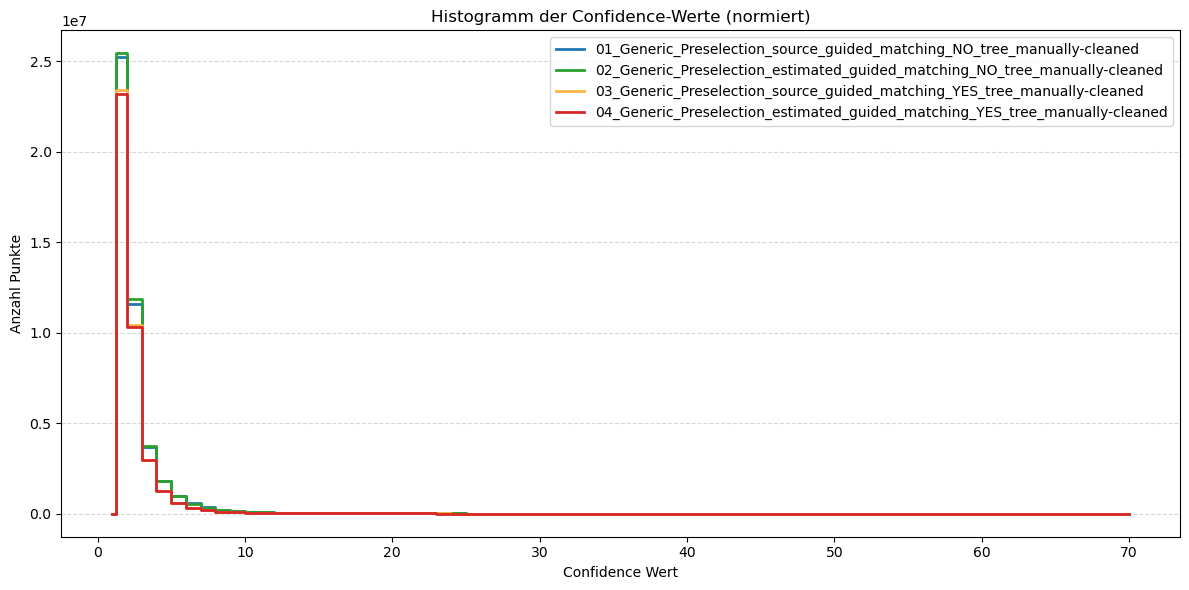

In [8]:
#============================================ Histogramm-Confidence-Werte - ANZAHL PUNKTE / DEZIMALSKALA ============================================

import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree_cleaned"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))
if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Funktion, um Confidence-Werte zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Daten vorbereiten
confidence_data = {}
min_vals = []
max_vals = []

for file in las_files:
    try:
        conf = get_confidence_values(file)
        confidence_data[file] = conf
        min_vals.append(np.min(conf))
        max_vals.append(np.max(conf))
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Gemeinsamen Wertebereich und Binning bestimmen
min_conf = min(min_vals)
max_conf = max(max_vals)
len_bins = max_conf - min_conf + 1
bins = np.linspace(int(min_conf), int(max_conf), int(len_bins))

# Plot vorbereiten
fig, ax = plt.subplots(figsize=(12, 6))

colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]
annotations = []

for i, (file, conf) in enumerate(confidence_data.items()):
    hist, edges = np.histogram(conf, bins=bins, density=False)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    x_ext = np.concatenate(([edges[0]], bin_centers, [edges[-1]]))
    y_ext = np.concatenate(([0], hist, [0]))
    
    label = os.path.splitext(os.path.basename(file))[0]
    ax.step(x_ext, y_ext, label=label, color=colors[i % len(colors)], linewidth=2, where="mid")
    
    annotations.append(f"{label}: {np.max(conf):.0f}")

# Achsen und Layout
ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Anzahl Punkte")
ax.set_title("Histogramm der Confidence-Werte (normiert)")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)


plt.tight_layout()
plt.show()


### 2.4 Histogramm der Confidence-Werte der Punktwolken (kontinuierlich) [Logarithmisch]
In dieser Visualisierung werden alle Punkte der Punktwolken in Bezug auf das Attribut "confidence" kontinuierlich (pro Wert eine Kategorie) eingeteilt. Pro Kategorie werden die normierten Anteile oder die Anzahl Punkte pro ImageAlignement-Methode dargestellt.


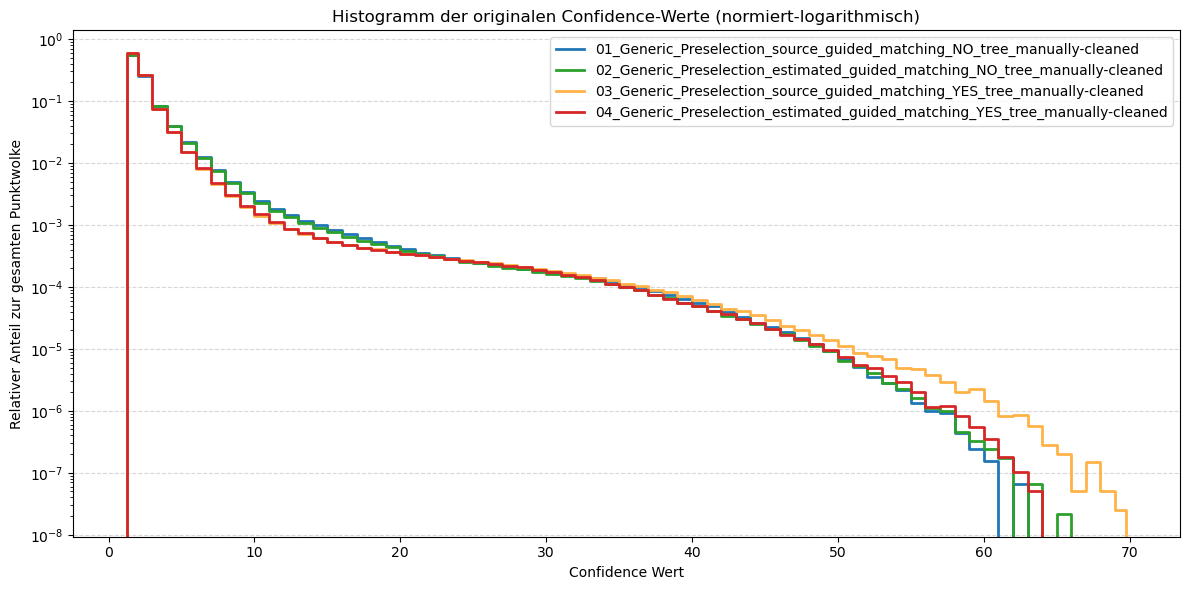

In [9]:
#============================================ Histogramm-Confidence-Werte - NORMIERT / LOGARITHMISCH ============================================

import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree_cleaned"

# Alle LAS-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))
if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Funktion, um Confidence-Werte zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Daten vorbereiten
confidence_data = {}
min_vals = []
max_vals = []

for file in las_files:
    try:
        conf = get_confidence_values(file)
        confidence_data[file] = conf
        min_vals.append(np.min(conf))
        max_vals.append(np.max(conf))
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Gemeinsamen Wertebereich und Binning bestimmen
min_conf = min(min_vals)
max_conf = max(max_vals)
len_bins = max_conf - min_conf + 1
bins = np.linspace(int(min_conf), int(max_conf), int(len_bins))

# Plot vorbereiten
fig, ax = plt.subplots(figsize=(12, 6))

colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]
annotations = []

for i, (file, conf) in enumerate(confidence_data.items()):
    hist, edges = np.histogram(conf, bins=bins, density=True)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    x_ext = np.concatenate(([edges[0]], bin_centers, [edges[-1]]))
    y_ext = np.concatenate(([0], hist, [0]))
    
    label = os.path.splitext(os.path.basename(file))[0]
    ax.step(x_ext, y_ext, label=label, color=colors[i % len(colors)], linewidth=2, where="mid")
    
    annotations.append(f"{label}: {np.max(conf):.0f}")

# Achsen und Layout
ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Relativer Anteil zur gesamten Punktwolke")
ax.set_title("Histogramm der originalen Confidence-Werte (normiert-logarithmisch)")
ax.set_yscale("log")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)


plt.tight_layout()
plt.show()


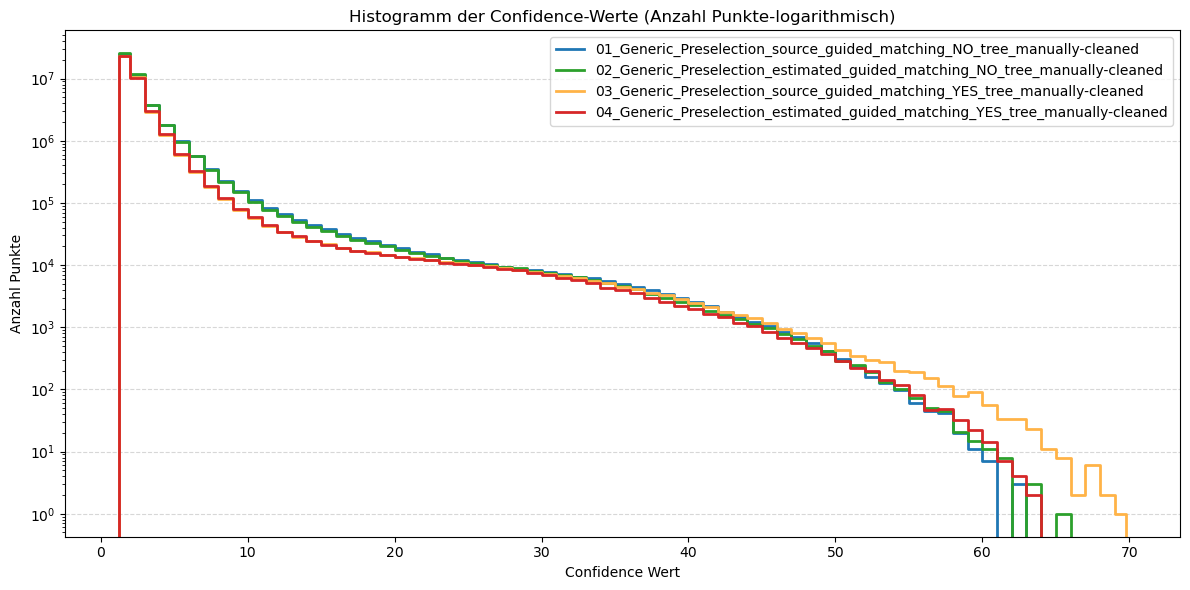

In [10]:
#============================================ Histogramm-Confidence-Werte - ANZAHL PUNKTE / LOGARITHMISCH ============================================

import os
import glob
import numpy as np
import laspy
import matplotlib.pyplot as plt

# Verzeichnis mit den LAS-Dateien
las_dir = "D:\\BTh11_Asuwertung_PC\\fhnw_code\\BTh11_Trieblaengenwachstum\\10_ImageAlignement_Testing\\100_BaseData\\PointCloud\\pc_tree_cleaned"

# Alle .las-Dateien im Verzeichnis finden
las_files = sorted(glob.glob(os.path.join(las_dir, "*.las")))
if not las_files:
    raise FileNotFoundError(f"Keine LAS-Dateien im Verzeichnis gefunden: {las_dir}")

# Funktion, um die Confidence-Werte aus einer LAS-Datei zu extrahieren
def get_confidence_values(file_path):
    las = laspy.read(file_path)
    if "confidence" not in las.point_format.dimension_names:
        raise ValueError(f"Feld 'confidence' fehlt in Datei: {file_path}")
    return las['confidence']

# Daten vorbereiten
confidence_data = {}
min_vals = []
max_vals = []

for file in las_files:
    try:
        conf = get_confidence_values(file)
        confidence_data[file] = conf
        min_vals.append(np.min(conf))
        max_vals.append(np.max(conf))
    except Exception as e:
        print(f"Fehler bei Datei {file}: {e}")

# Gemeinsames Binning für alle Dateien
min_conf = min(min_vals)
max_conf = max(max_vals)
len_bins = max_conf - min_conf + 1
bins = np.linspace(int(min_conf), int(max_conf), int(len_bins))

# Bin-Zentren berechnen
bin_centers = (bins[:-1] + bins[1:]) / 2
x_extended = np.concatenate(([bins[0]], bin_centers, [bins[-1]]))

# Plot vorbereiten
fig, ax = plt.subplots(figsize=(12, 6))
colors = ["#1f77b4", "#2ca02c", "#FFB347", "#d62728"]

# Für jede Datei das Histogramm berechnen und als Stufenplot darstellen
for i, (file, conf) in enumerate(confidence_data.items()):
    hist, _ = np.histogram(conf, bins=bins, density=False)
    y_extended = np.concatenate(([0], hist, [0]))
    label = os.path.splitext(os.path.basename(file))[0]
    ax.step(x_extended, y_extended, where="mid", label=label, linewidth=2, color=colors[i % len(colors)])

# Achsenbeschriftung & Layout
ax.set_xlabel("Confidence Wert")
ax.set_ylabel("Anzahl Punkte")
ax.set_title("Histogramm der Confidence-Werte (Anzahl Punkte-logarithmisch)")
ax.set_yscale("log")
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()
